In [649]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

In [650]:
stai_scores = np.array(pd.read_csv(r'stai_scores.csv', header=None)[0])
inst_choices = np.array(pd.read_csv(r'inst_choices.csv', header=None))
inst_outcomes = np.array(pd.read_csv(r'inst_outcomes.csv', header=None))

### Data exploration

In [651]:
# Exploring the data: mean, median, standard deviation of STAI
overall_mean = np.mean(stai_scores)
overall_std = np.std(stai_scores)
overall_median = np.median(stai_scores)

anxious_mean = np.mean(stai_scores[0:24])
anxious_std = np.std(stai_scores[0:24])
anxious_median = np.median(stai_scores[0:24])

control_mean = np.mean(stai_scores[25:])
control_std = np.std(stai_scores[25:])
control_median = np.median(stai_scores[25:])

In [652]:
# Exploring the data: cut-off = 43, ANXIOUS group if STAI>43
cut_off_stai = np.zeros(len(stai_scores))
for i in range(len(stai_scores)):
    if stai_scores[i] <= 43:
        # cut_off_stai = 1 if the subject is in the healthy control group
        cut_off_stai[i] = 1

healthy_num = sum(cut_off_stai)
healthy_index = np.where(cut_off_stai==1)

In [653]:
# Exploring the data: number of times each subject choosing stimuli A
chose_a_count = []
chose_a_percent = []
for i in range(len(inst_choices)):
    chose_a_count.append(np.array(np.where(inst_choices[i]==1)).size)
    chose_a_percent.append(chose_a_count[-1]/len(inst_choices[i]))

### Simulation


In [654]:
# Value of a chosen stimuli i at time t, and the overall outcome
# the probability of each stimulus to lead to the aversive noise, 70/30, 80/20, 60/40, 65/35 (A/B)
# A reinforcement learning model, the Rescorla-Wagner model, to update the subjective value
# of A and B after each trial. The value of A and B at trial i+1 is updated based on
# the prediction error of the chosen option at trial i. This means that
# if the outcome is better than expected, the subjective value of the chosen option is increased, and 
# if the outcome is worse than expected, the subjective value of the chosen option is decreased. 
# This model assumes that the subjective value of an option is updated in response to feedback.
np.random.seed(1)
prob_list = [[0.3,0.7],[0.2,0.8],[0.4,0.6],[0.35,0.65]]

def outcome(a,b,p,V0):
    
    outcome = np.zeros(160)
    value_a = [V0]
    value_b = [V0]
    prob = np.repeat(p,40,axis=0)
    
    for i in range(160):
        p_a = np.exp(-b*value_a[i])/(np.exp(-b*value_a[i])+np.exp(-b*value_b[i]))
        p_b = 1-p_a
        choice = np.random.choice([0,1],p=[p_a,p_b])
        if choice == 0:
            outcome[i] = np.random.choice([0,1],p=prob[i])
            value_a.append(value_a[-1]+a*(outcome[i]-value_a[-1]))
            value_b.append(value_b[-1])
        else:
            outcome[i] = np.random.choice([0,1],p=1-prob[i])
            value_b.append(value_b[-1]+a*(outcome[i]-value_b[-1]))
            value_a.append(value_a[-1])

    return outcome, value_a, value_b, sum(outcome)


# if correct, 'np.mean(test)' should be around 58
test = []
for i in range(1000):
    test.append(outcome(0.4,7,prob_list,0.5)[-1])
np.mean(test)

58.124

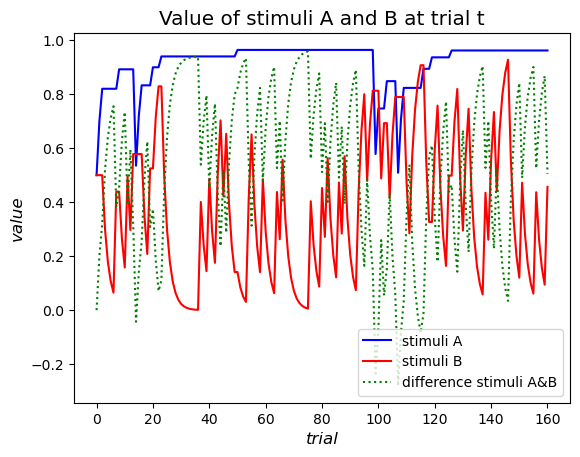

In [660]:
# Simulation: a = 0.4, b = 7, V0 = 0.5
np.random.seed(1)
sample = outcome(0.4,7,prob_list,0.5)
value_a = sample[1]
value_b = sample[2]
plt.title('Value of stimuli A and B at trial t', fontsize = 'x-large')
plt.plot(value_a, color = 'b', label = "stimuli A")
plt.plot(value_b, color = 'r', label = "stimuli B")
plt.plot(np.array(value_a)-np.array(value_b), color = 'g', linestyle = 'dotted', label = "difference stimuli A&B")
plt.xlabel('trial', fontsize = 'large', fontstyle = 'italic')
plt.ylabel('value', fontsize = 'large', fontstyle = 'italic')
plt.legend(loc='lower right')

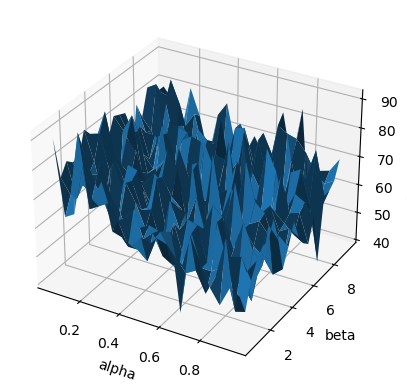

In [703]:
# Plot the average number of aversive stimuli received as a function of the parameter settings
# alpha determines the rate of learning, with higher values leading to faster learning. 
# beta determines the sensitivity to reward prediction errors, with higher values leading 
# to greater sensitivity. Thus, a higher alpha value may lead to faster adaptation to changes 
# in the environment, while a higher beta value may lead to more cautious behavior and fewer 
# aversive outcomes. However, there may be trade-offs between these parameters, as increasing 
# one parameter may negatively affect performance if the other parameter is not also adjusted appropriately. 

np.random.seed(1)
num = 20
sim_mat = np.zeros([num,num])
alpha = (np.linspace(0,1,num+1,endpoint=False)[1:])
beta = (np.linspace(0,10,num+1,endpoint=False)[1:])
for i in range(num):
    for j in range(num):
        sim_mat[i][j] = outcome(alpha[i],beta[j],prob_list,0.5)[-1]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.view_init(0, 0)
X, Y = np.meshgrid(alpha, beta)
ax.plot_surface(X, Y, sim_mat)
ax.set_xlabel('alpha')
ax.set_ylabel('beta')
ax.set_zlabel('avg aversive stimuli')
plt.show()

### Likelihood function